### Retrieving the street network and sampling it

Sampling the network allows to determine points where calculations will be made or where street view images will be obtained for analysis. 

Exported: data/network.geojson


<Axes: >

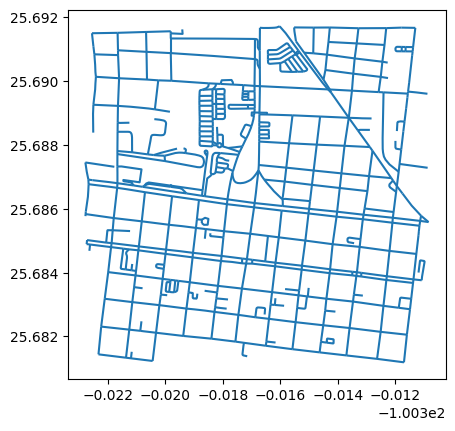

In [1]:
from alivestreets.network import network_retrieval, osm_features
from alivestreets.sampling.street_sampler import StreetSampler
import geopandas as gpd
import alivestreets as ast

lat = 25.6865415470827
lon = -100.31682261963644
radius = 600

graph = network_retrieval.get_graph_from_point(lat, lon, radius)
network_path = "data/network.geojson"
network_retrieval.export_graph_geojson(graph, network_path)

gdf = gpd.read_file(network_path)
gdf.plot()


In [2]:
from alivestreets.network import osm_features

lat = 25.6865415470827
lon = -100.31682261963644
radius = 600

osm_features.export_all_from_point("data/features", lat, lon, radius)

No features found for PlaceType.PARKS: No matching features. Check query location, tags, and log.
Exported data/features/amenities.geojson
Exported data/features/bus_stops.geojson
Exported data/features/schools.geojson
Exported data/features/job_centers.geojson
No features found for PlaceType.INSTITUTIONS: No matching features. Check query location, tags, and log.
Exported data/features/homes.geojson
No features found for PlaceType.CENSUS_BLOCK: No matching features. Check query location, tags, and log.
Exported data/features/subway.geojson


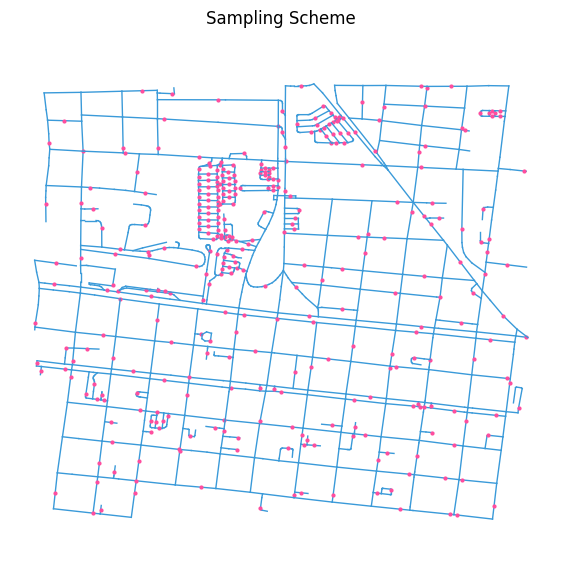

In [3]:
from alivestreets.sampling.street_sampler import StreetSampler

# Create a StreetSampler with a maximum number of sampling points
sampler = StreetSampler(max_points=200)

# Load the exported network
sampler.open_streets("data/network.geojson")

# Sample the streets
sampler.sample_streets_no_intersections()

# Optional: draw sampling scheme
sampler.draw_sampling_scheme(width=7, height=7, node_size = 2)


### Tagging properties of the sampling points

Other notebooks will deal with the taggin of street view properties. For now i will exemplify the tagging of some mesoscopic features of interest. Specifically here  i will show how to tag average distance from points on a street to amenities of certain types (schools for demonstration). The distances that will be illustrated are distance within the network from point $p$ to an amenity $a$ which we might denote as $D_{n}(p, a)$ and the corresponding distance following a geodesic $D_{g}(p, a)$. Geodesic is just the curve you trace when you walk on a sphere, which is what you get approximately when you travel on earth. For small distances it is very similar to the euclidean distance. Well, actually i think the geodesic can be defined for any manifold, but the most common illustration is a sphere. 

This is the haversine formula

\begin{equation}
D_{g}(p, a) = 2 \arcsin\left( \sqrt{ \sin^2\left( \frac{p_{\text{lat}} - a_{\text{lat}}}{2} \right) + \cos(p_{\text{lat}}) \cos(a_{\text{lat}}) \sin^2\left( \frac{p_{\text{lon}} - a_{\text{lon}}}{2} \right) } \right)
\end{equation}

Well if the angle is very small you can do the approximations $\sin(\theta) \approx \theta$, $\cos(\theta) \approx 1$ and $\arcsin(\theta) \approx \theta$

So the equation is simplified to:

\begin{equation}
D_{g}(p, a) = 2 \sqrt{ \left( \frac{p_{\text{lat}} - a_{\text{lat}}}{2} \right)^2 + (1) (1) \left( \frac{p_{\text{lon}} - a_{\text{lon}}}{2} \right)^2 } = \sqrt{(p_{\text{lat}} - a_{\text{lat}})^2 + (p_{\text{lon}} - a_{\text{lon}})^2}
\end{equation}

which is the euclidean distance.

Although this is interesting, it is tangential to the story. The angle approximations can be deduced by looking at the Taylor series expansions for sine, cosine and arcsine functions. 

Once you have the geodesic and the network distances between a point and an amenity the efficiency of traveling from the point to the amenity in the city can be obtained in the following way:


$$e(p, a) = \frac{D_{g}(p, a)}{D_{n}(p,a)}$$

since ideally $D_{n} \geq D_{g}$ the previous quanity is a number that goes from 0 to 1. Although this can be subject to computational errors. If the point and amenity are projected to weird edges in the network that are far away from their original points the inequality might not hold. 

<span style="color: red">Projections to lines are linear BUT PROJECTIONS TO NETWORKS ARE NON-LINEAR!!!</span>

this non-linearity might create errors if you are not careful, it is better to choose points and amenities that are already close to the street network.

### Network distance to schools

In [4]:
#Let's tag the network with properties for simplicity let's simply do the distance to the nearest amenity at each point. 
import os

#Open the geodataframe
gdf = gpd.read_file(os.path.join(os.getcwd(), "data", "features", "schools.geojson"))
amenity_points = list(gdf["geometry"])
amenity_points = [[p.x, p.y] for p in amenity_points]


#Get the min distance of the sampling points to schools
#this is one of the simple mesoscopic properties that can be obtained
sampling_points = sampler.get_all_sampling_points()

from alivestreets.features.mesoscopic import get_min_network_distances_to_amenities
from alivestreets.network.graph_utilities import build_graph_from_sampler

graph = build_graph_from_sampler(sampler)
network_distances = get_min_network_distances_to_amenities(sampling_points, amenity_points, graph)

#Let's tag the streets in the sampler
sampler.tag_streets(
    "min_amenity_network_distance", 
    network_distances,
    method = "mean"

)


100%|██████████| 355/355 [00:46<00:00,  7.59it/s]


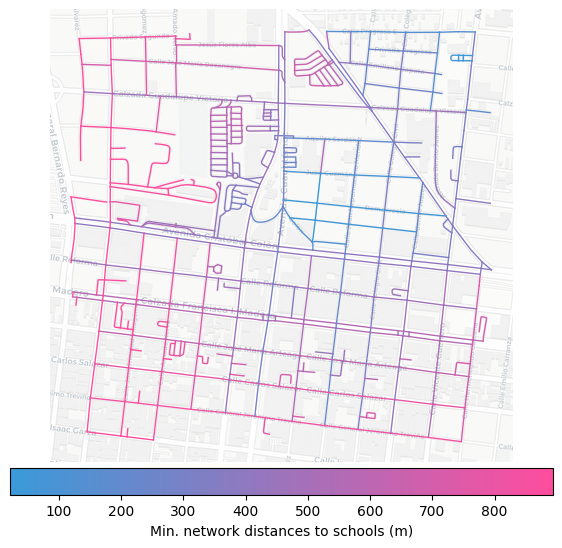

In [5]:
from alivestreets.visualization.map_visualizer import MapVisualizer

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(sampler, 
"min_amenity_network_distance", 
variable_type="continuous",
edge_width = 1)
#This will show the property averaged over all sampling points of a street, that is, every street receives a unique value of the property
vis.draw_networks(colorbar_label = "Min. network distances to schools (m)", colorbar_orientation = "horizontal")
#You can add a base map if you want here i show it with 0.7 transparency
vis.add_basemap(alpha = 0.7)
vis.finalize_map()

### Geodesic distance to schools

100%|██████████| 355/355 [00:00<00:00, 75452.41it/s]


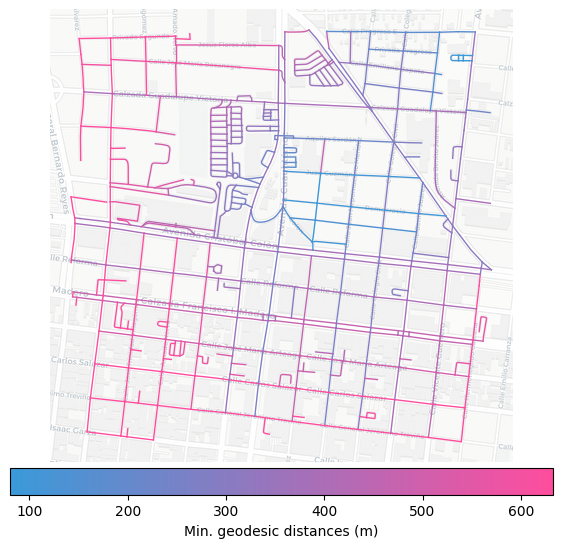

In [6]:

from alivestreets.features.mesoscopic import get_min_geodesic_distances_to_amenities
from alivestreets.sampling.geometry import project_point_onto_graph_edges

#If the plan is to compare geodesics with network distances it is important to project the amenities, otherwise you might get that
#geodesic distances are longer than within the network, which would not make sense, birds always get somewhere faster than humans (assuming super birds 
# flying at automobile speeds)
projected_points = [project_point_onto_graph_edges(graph, x) for x in sampling_points]
projected_amenities = [project_point_onto_graph_edges(graph, x) for x in amenity_points]
geodesic_distances = get_min_geodesic_distances_to_amenities(projected_points, projected_amenities)

sampler.tag_streets(
    "min_amenity_geodesic_distance", 
    geodesic_distances,
    method = "mean"
)


vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(sampler, 
"min_amenity_geodesic_distance", 
variable_type="continuous",
edge_width = 1)
#This will show the property averaged over all sampling points of a street, that is, every street receives a unique value of the property
vis.draw_networks(colorbar_label = "Min. geodesic distances (m)", colorbar_orientation = "horizontal")
#You can add a base map if you want here i show it with 0.7 transparency
vis.add_basemap(alpha = 0.7)
vis.finalize_map()

### Travel efficiency to schools


The travel efficiency can be defined as 

\begin{equation}
\epsilon = \frac{\text{Geodesic distance}}{\text{Network distance}}
\end{equation}

This quanitty is usually called circuity. The term makes me think of loops, which is not what the metric describes so i don't usually use it. 

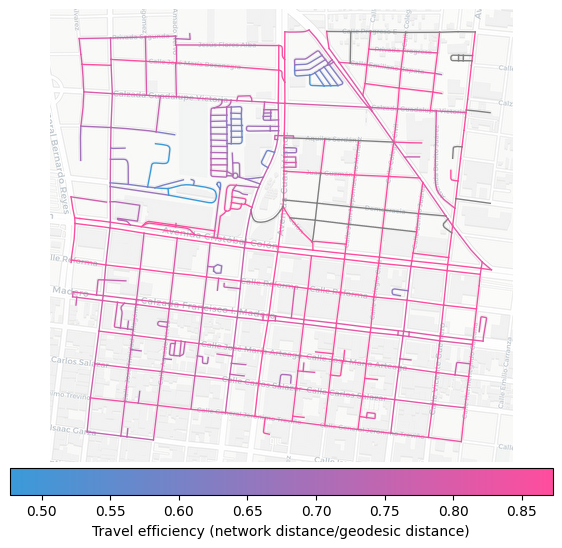

In [7]:
efficiencies = [
    None if network_distances[i] == 0 or 
            geodesic_distances[i] is None or 
            network_distances[i] is None or 
            geodesic_distances[i] / network_distances[i] > 1
    else geodesic_distances[i] / network_distances[i]
    for i in range(len(geodesic_distances))
]

sampler.tag_streets(
    "travel_efficiency", 
    efficiencies,
    method = "mean"
)


vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(sampler, 
"travel_efficiency", 
variable_type="continuous",
edge_width = 1)
vis.draw_networks(colorbar_label = "Travel efficiency (network distance/geodesic distance)", colorbar_orientation = "horizontal")
vis.add_basemap(alpha = 0.7)
vis.finalize_map()


In general the travel efficiency seems to be high in this case. You can plot the distribution:

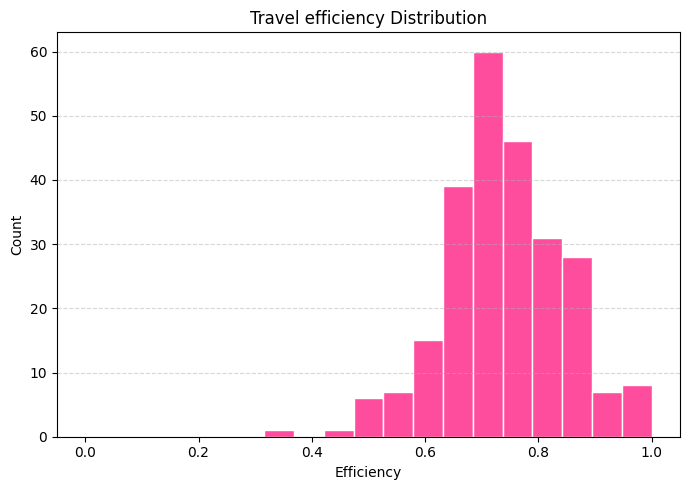

In [8]:
import numpy as np
import matplotlib.pyplot as plt

valid_efficiencies = [street.attributes["travel_efficiency"] for street in sampler.streets if not street.attributes["travel_efficiency"] is None]

bins = np.linspace(0, 1, 20)
plt.figure(figsize=(7, 5))
plt.hist(valid_efficiencies, bins=bins, color="#FF4D9E", edgecolor="white")

plt.title("Travel efficiency Distribution")
plt.xlabel("Efficiency")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()